---
# **Prepare Libraries and Data**
---

---
### **Import Libraries**
---

In [80]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, f1_score
from sklearn.metrics import precision_recall_curve, precision_score, average_precision_score
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [81]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loi.dai.dang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\loi.dai.dang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

---
### **Reading Data**
---

In [118]:
path = 'https://raw.githubusercontent.com/dangdailoi/NLP/main/Restaurant%20reviews.csv'
df = pd.read_csv(path)

In [119]:
data = df[['Review', 'Rating']]
data.dropna(inplace=True)

C:\Users\loi.dai.dang\AppData\Local\Temp\ipykernel_24260\4262704893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


---
# **Exploratory Analysis**
---

---
### **Build Data Processing Functions**
---

In [90]:
def convert_to_label(label) -> int:
    return 1 if label in ['4','5'] else 0

In [91]:
def clean_text(text):
    words = text.lower().split()
    words = [word.lower().translate(str.maketrans('', '', string.punctuation)) for word in words]

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    processed_text = ' '.join(words)

    return processed_text

In [92]:
def formatting_data(data: pd.DataFrame) -> pd.DataFrame:
    data = data.rename(columns={'Phrase':'Review'})
    data['Review'] = data['Review'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', "", x))
    data['Review'] = data['Review'].apply(clean_text)
    data['Rating'] = data['Rating'].apply(convert_to_label)
    data['Sentiment'] = data['Rating'].map({0:'Negative',1:'Positive'})
    data.drop_duplicates(inplace=True)
    data['ReviewLength'] = data['Review'].apply(lambda x: len(x))
    data = data[data["ReviewLength"] != 0]
    return data

### **Build Visualization Functions**

In [93]:
def draw_bar_chart(data, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=data, hue=column, palette='viridis')

    plt.title(f'Bar chart for {column}')
    plt.xlabel(column)
    plt.ylabel('Counts')

    plt.show()

In [94]:
def draw_pie_chart(data, column):
  counts = data[column].value_counts()

  sns.set(style="whitegrid")
  colors = sns.color_palette("pastel")

  plt.figure(figsize=(8, 8))
  plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

  plt.title(f'Pie chart for {column}')
  plt.show()

In [95]:
def plot_review_length_distribution(data):
    plt.figure(figsize=(16, 7))
    bins = np.linspace(0, 200, 50)
    plt.hist(data[data['Sentiment'] == 'Positive']['ReviewLength'], bins=bins, density=True, alpha=0.5, label='Positive')
    plt.hist(data[data['Sentiment'] == 'Negative']['ReviewLength'], bins=bins, density=True, alpha=0.5, label='Negative')
    plt.xlabel('Review Length')
    plt.ylabel('Density')
    plt.title('Review Length Distribution by Sentiment')
    plt.legend()
    plt.yticks([])
    plt.show()

In [96]:
def draw_word_cloud(data):
    data['Review'] = data['Review'].astype(str)
    data = data[~data['Review'].str.isspace()]
    positive_reviews = " ".join(data[data['Rating'] == 1]['Review'])
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
    negative_reviews = " ".join(data[data['Rating'] == 0]['Review'])
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Positive Sentiment')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Negative Sentiment')
    plt.axis("off")
    plt.show()

In [97]:
def draw_sent_chart(data, sentiment, color='viridis', top_n=20):
    sen_text_list = data[data['Sentiment'] == sentiment]['Review'].tolist()
    sen_total_words = ' '.join(sen_text_list)
    sen_total_words = word_tokenize(sen_total_words)
    sen_freq_words = FreqDist(sen_total_words)
    freq_df = pd.DataFrame(sen_freq_words.items(), columns=['Word', 'Frequency']).nlargest(top_n, 'Frequency')

    plt.figure(figsize=(16, 6))
    sns.barplot(x='Word', y='Frequency', data=freq_df, palette=color)
    plt.title(f'Top {top_n} most frequent words in {sentiment} reviews')
    plt.xlabel('Words')
    plt.xticks(rotation=45)
    plt.show()

In [98]:
def plot_history(history):
  df_history = pd.DataFrame({
      'Epoch': range(1, len(history.history['loss']) + 1),
      'Training Loss': history.history['loss'],
      'Validation Loss': history.history['val_loss'],
      'Training Accuracy': [acc * 100 for acc in history.history['accuracy']],
      'Validation Accuracy': [val_acc * 100 for val_acc in history.history['val_accuracy']]
  })

  # Vẽ biểu đồ
  plt.figure(figsize=(10, 5))
  # Tìm epoch có Training Accuracy tốt nhất
  best_epoch = df_history.loc[df_history['Training Accuracy'].idxmax()]

  print(f"Epoch with the best training accuracy: {best_epoch['Epoch']} with accuracy: {best_epoch['Training Accuracy']:.2f}%")

  # Loss plot
  plt.subplot(1, 2, 1)
  sns.lineplot(data=df_history, x='Epoch', y='Training Loss', label='Training Loss')
  sns.lineplot(data=df_history, x='Epoch', y='Validation Loss', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy plot
  plt.subplot(1, 2, 2)
  sns.lineplot(data=df_history, x='Epoch', y='Training Accuracy', label='Training Accuracy')
  sns.lineplot(data=df_history, x='Epoch', y='Validation Accuracy', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [99]:
def plot_confusion_matrices(model_names, models, test_data_list, true_labels_list):
    fig, axes = plt.subplots(1, len(models), figsize=(15, 5))  # Adjust the size as needed

    for ax, model, name, test_data, true_labels in zip(axes, models, model_names, test_data_list, true_labels_list):
        # Ensure data is in numpy array format
        if isinstance(test_data, list):
            test_data = np.array(test_data)

        # Debugging: Print shape of the data
        #print(f"Data shape for {name}: {test_data.shape}")

        # Predict the test data
        if name == 'LSTM':
            y_pred_prob = model.predict(test_data)
            y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary labels
        else:
            y_pred = model.predict(test_data)

        # Debugging: Check unique values of y_pred
        #print(f"Unique predicted values for {name}: {np.unique(y_pred)}")

        # Generate confusion matrix
        cm = confusion_matrix(true_labels, y_pred)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(f'Model: {name}')
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])

    plt.tight_layout()
    plt.show()

In [100]:
def compare_models_performance(model_names, models, test_data_list, true_labels_list):
    results = []

    for name, model, test_data, true_labels in zip(model_names, models, test_data_list, true_labels_list):
        if name == 'LSTM':
            predictions = (model.predict(test_data) > 0.5).astype(int).flatten()
        else:
            predictions = model.predict(test_data)

        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, zero_division=0)
        recall = recall_score(true_labels, predictions, zero_division=0)
        f1 = f1_score(true_labels, predictions, zero_division=0)
        auc = roc_auc_score(true_labels, predictions)

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
        })

    df = pd.DataFrame(results)
    return df.style.background_gradient(cmap='Blues')

In [101]:
def plot_precision_recall_curves(model_names, models, test_data_list, true_labels_list):
    plt.figure(figsize=(8, 6))

    for model, test_data, label, true_labels in zip(models, test_data_list, model_names, true_labels_list):
        if label == 'LSTM':
            probs = model.predict(test_data).ravel()
        else:
            probs = model.predict_proba(test_data)[:, 1]

        precision, recall, _ = precision_recall_curve(true_labels, probs)
        pr_auc = average_precision_score(true_labels, probs)

        plt.plot(recall, precision, lw=2, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.show()

In [102]:
def plot_roc_curves(model_names, models, test_data_list, true_labels_list):
    plt.figure(figsize=(8, 6))

    for model, test_data, label, true_labels in zip(models, test_data_list, model_names, true_labels_list):
        if label == 'LSTM':
            probs = model.predict(test_data).ravel()
        else:
            probs = model.predict_proba(test_data)[:, 1]

        fpr, tpr, _ = roc_curve(true_labels, probs)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

---
### **Data Processing**
---

In [121]:
data.describe().T.style.background_gradient(axis=1)

,count,unique,top,freq
Review,9955,9364,good,237
Rating,9955,10,5,3826


In [122]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

In [123]:
data.head()

,Review,Rating
0,"The ambience was good, food was quite good . h...",5
1,Ambience is too good for a pleasant evening. S...,5
2,A must try.. great food great ambience. Thnx f...,5
3,Soumen das and Arun was a great guy. Only beca...,5
4,Food is good.we ordered Kodi drumsticks and ba...,5


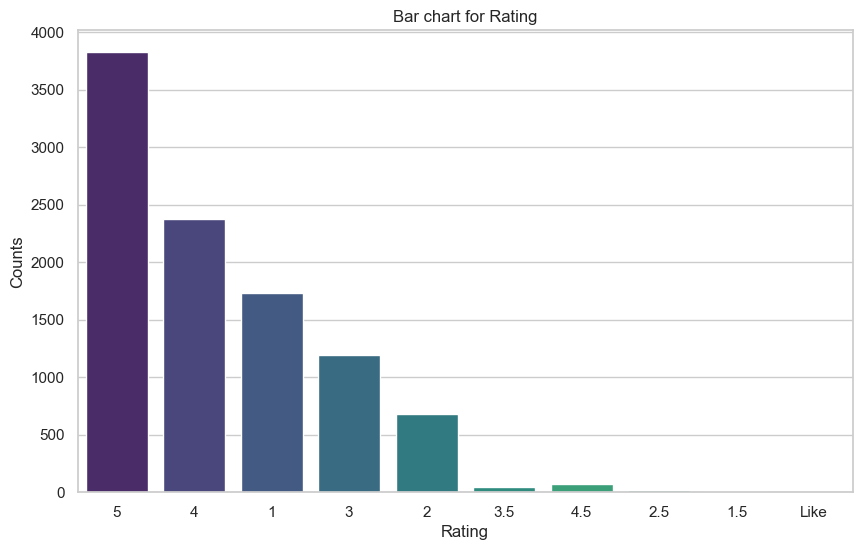

In [124]:
draw_bar_chart(data, 'Rating')

Từ bảng dữ liệu và biểu đồ cột Rating, chúng ta có thể thấy bộ dữ liệu bao gồm hai cột: văn bản đánh giá của người dùng và điểm Rating của họ. Do các điểm 4 và 5 chiếm phần lớn tỷ lệ trong dữ liệu, chúng ta sẽ gộp các điểm này thành một nhãn và các điểm còn lại thành một nhãn khác để khi huấn luyện mô hình sẽ không bị thiên lệch. Cụ thể, chúng ta sẽ xử lý các điểm Rating thành hai nhãn là 0 và 1 như sau:

*   0: Tiêu cực
*   1: Tích cực

In [125]:
data = formatting_data(data)

In [126]:
print(f'Bộ dữ liệu sau khi xử lý có {data.shape[0]} dòng và {data.shape[1]} cột')

data.head()

Bộ dữ liệu sau khi xử lý có 9179 dòng và 4 cột


,Review,Rating,Sentiment,ReviewLength
0,ambienc good food quit good saturday lunch cos...,1,Positive,144
1,ambienc good pleasant even servic prompt food ...,1,Positive,84
2,must tri great food great ambienc thnx servic ...,1,Positive,124
3,soumen da arun great guy behavior sincereti go...,1,Positive,82
4,food goodw order kodi drumstick basket mutton ...,1,Positive,106


### **Data Visualization**

In [127]:
data.describe().T.style.background_gradient(axis=1)

,count,mean,std,min,25%,50%,75%,max
Rating,9179.000000,0.604314,0.489024,0.000000,0.000000,1.000000,1.000000,1.000000
ReviewLength,9179.000000,182.009805,203.683317,1.000000,93.000000,125.000000,202.000000,3403.000000


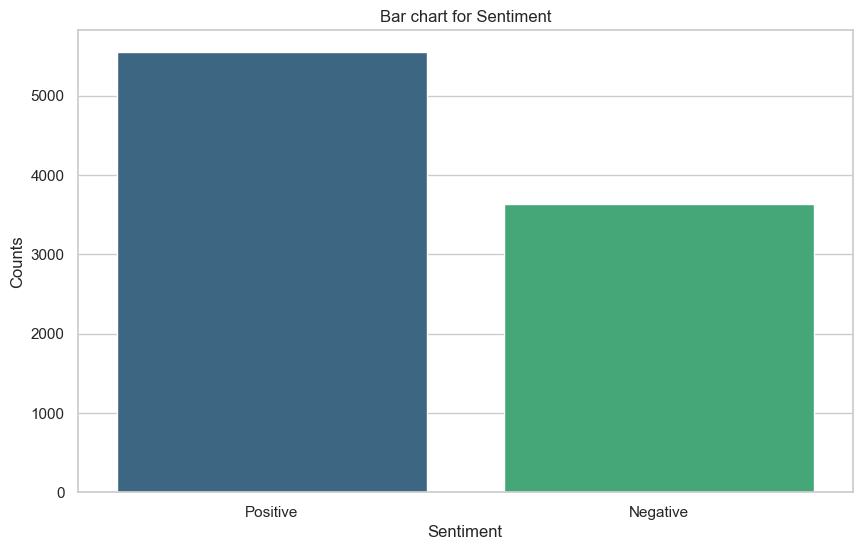

In [128]:
draw_bar_chart(data, 'Sentiment')

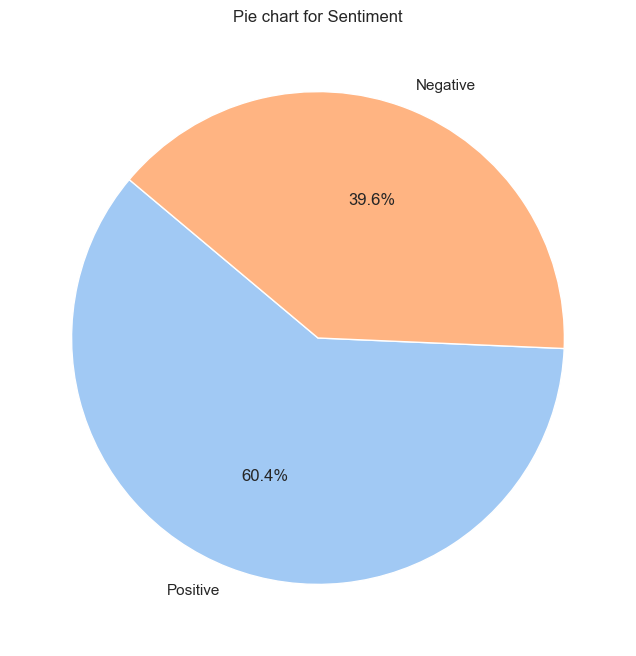

In [129]:
draw_pie_chart(data, 'Sentiment')

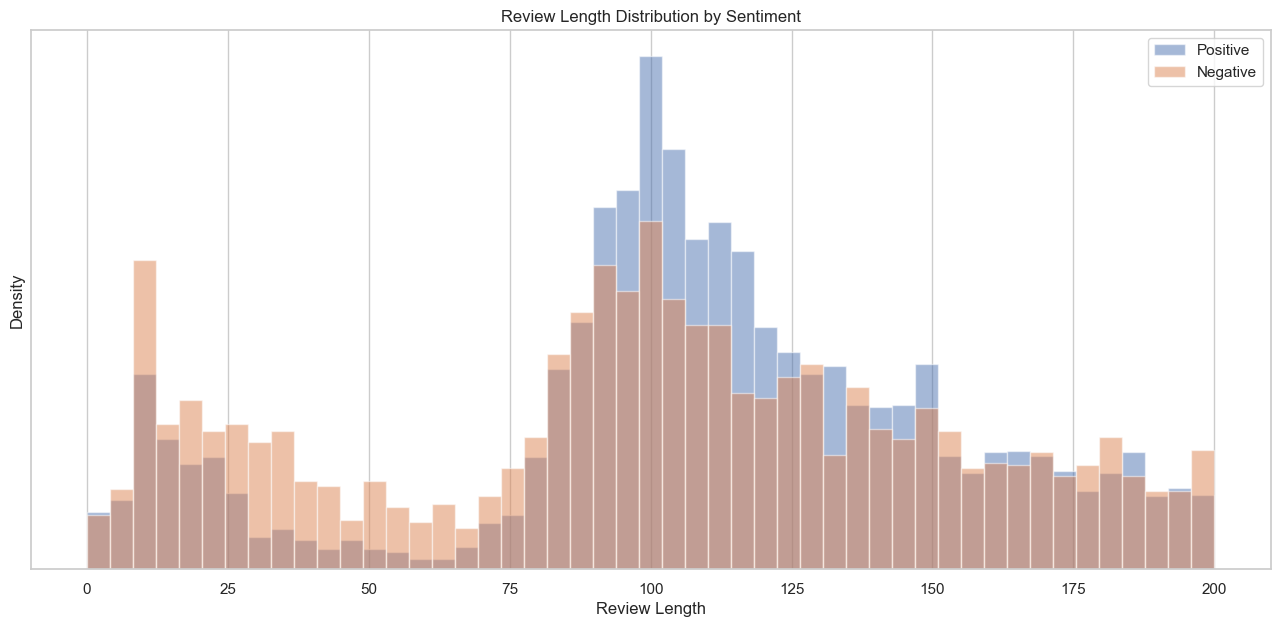

In [130]:
plot_review_length_distribution(data)

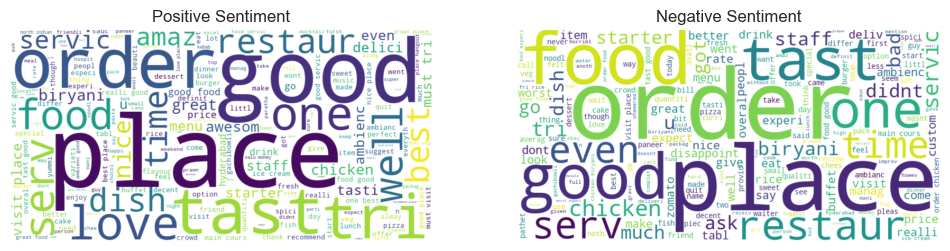

In [131]:
draw_word_cloud(data)

C:\Users\loi.dai.dang\AppData\Local\Temp\ipykernel_24260\1775044889.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=freq_df, palette=color)


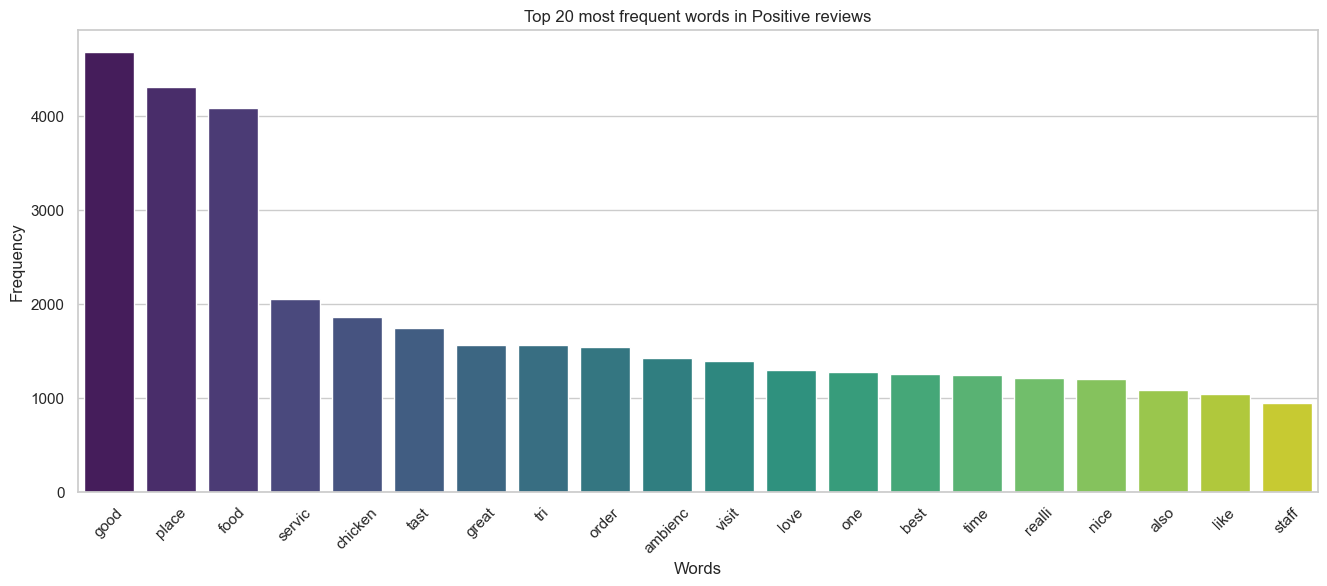

In [132]:
draw_sent_chart(data, 'Positive')

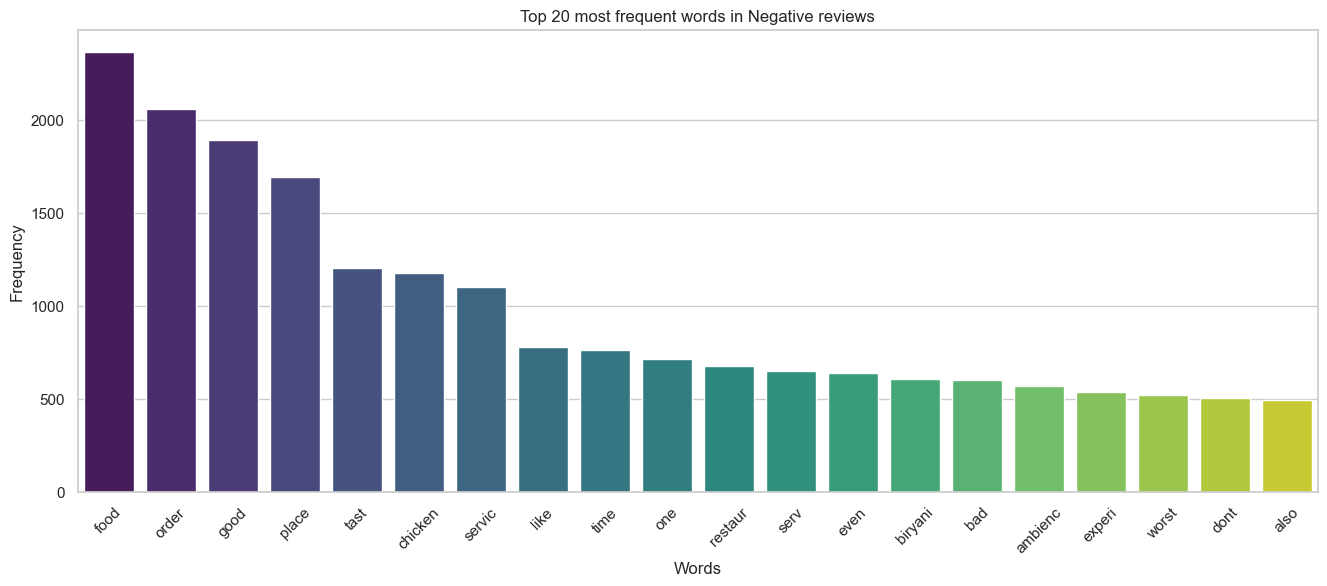

In [133]:
draw_sent_chart(data, 'Negative')

---
# **Machine Learning**
---

In [34]:
# Chia tập dữ liệu thành train và test
X_train, X_tem, y_train, y_tem = train_test_split(data['Review'], data['Sentiment'], test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_tem, y_tem, test_size=0.5, random_state=42)

### **Data Training Naive Bayes, SVM**

In [35]:
# Tiền xử lý văn bản
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_val_tfidf = vectorizer.transform(X_test)

# Mã hóa nhãn
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_test)

target_names = [str(cls) for cls in label_encoder.classes_]

### **Data Training LSTM**

In [135]:
# Tokenize the text
max_words = 1000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(data['Review'].values)
X = tokenizer.texts_to_sequences(data['Review'].values)
X = pad_sequences(X)
y = data['Rating']

In [138]:
# Split the data
X_train_lstm, X_tem_lstm, y_train_lstm, y_tem_lstm = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_lstm, X_val_lstm, y_test_lstm, y_val_lstm = train_test_split(X_tem_lstm, y_tem_lstm, test_size=0.5, random_state=42)

## **Naive Bayes**

In [39]:
# Huấn luyện mô hình Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_encoded)

MultinomialNB()

In [40]:
# Dự đoán và đánh giá
y_pred_nb = nb_model.predict(X_val_tfidf)

In [41]:
print("Naive Bayes Classification Report:\n", classification_report(y_val_encoded, y_pred_nb, target_names=target_names))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.59      0.71       328
    Positive       0.81      0.96      0.88       590

    accuracy                           0.83       918
   macro avg       0.86      0.78      0.80       918
weighted avg       0.84      0.83      0.82       918



## **SVM**

In [42]:
# Huấn luyện mô hình SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_tfidf, y_train_encoded)

SVC(kernel='linear', probability=True)

In [43]:
# Dự đoán và đánh giá
y_pred_svm = svm_model.predict(X_val_tfidf)

In [44]:
print("SVM Classification Report:\n", classification_report(y_val_encoded, y_pred_svm, target_names=target_names))

SVM Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.81      0.81       328
    Positive       0.90      0.89      0.89       590

    accuracy                           0.86       918
   macro avg       0.85      0.85      0.85       918
weighted avg       0.86      0.86      0.86       918



## **LSTM**

In [139]:
# Build the LSTM model
embedding_dim = 128
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, embedding_dim, input_length=X.shape[1]))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [141]:
# Train the model
batch_size = 32
epochs = 10
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size, validation_data=(X_val_lstm, y_val_lstm))

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 91s 384ms/step - accuracy: 0.7107 - loss: 0.5461 - val_accuracy: 0.8508 - val_loss: 0.3504
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 353ms/step - accuracy: 0.8730 - loss: 0.3103 - val_accuracy: 0.8573 - val_loss: 0.3365
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 80s 348ms/step - accuracy: 0.8917 - loss: 0.2777 - val_accuracy: 0.8584 - val_loss: 0.3461
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 356ms/step - accuracy: 0.8928 - loss: 0.2641 - val_accuracy: 0.8627 - val_loss: 0.3501
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 84s 366ms/step - accuracy: 0.8957 - loss: 0.2608 - val_accuracy: 0.8399 - val_loss: 0.3793
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 86s 373ms/step - accuracy: 0.9044 - loss: 0.2483 - val_accuracy: 0.8627 - val_loss: 0.3490
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 352ms/step - accuracy: 0.9128 - loss: 0.2192 - val_accuracy: 0.8573 - val_loss: 0.3709
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 352ms/step - accuracy: 0.9208 - loss: 0

In [142]:
# Dự đoán và đánh giá trên tập test
y_pred_lstm = lstm_model.predict(X_val_lstm)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)
print("LSTM Classification Report:\n", classification_report(y_val_encoded, y_pred_lstm, target_names=target_names))

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.77      0.78       368
    Positive       0.85      0.87      0.86       550

    accuracy                           0.83       918
   macro avg       0.82      0.82      0.82       918
weighted avg       0.83      0.83      0.83       918



Epoch with the best training accuracy: 10.0 with accuracy: 97.74%


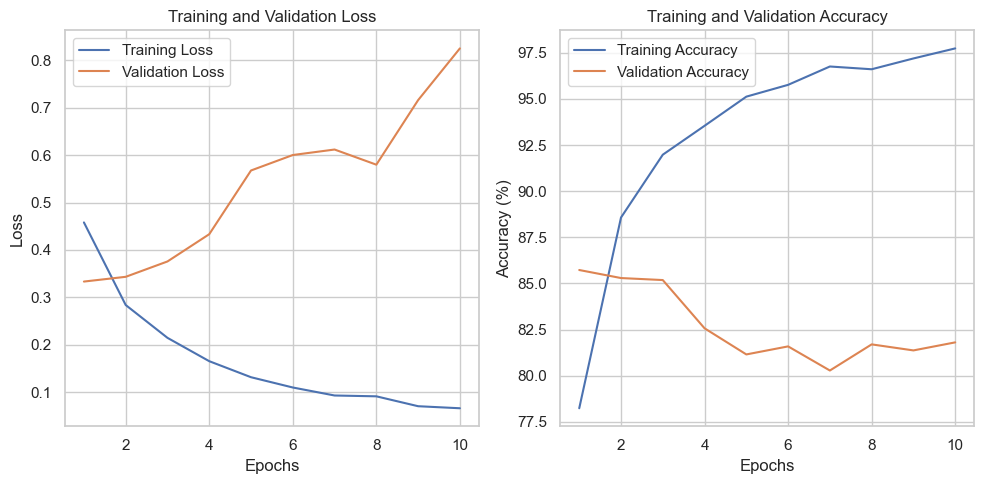

In [51]:
plot_history(history)

---
# **Evaluation**
---

In [144]:
model_names = ['Naive Bayes', 'SVM', 'LSTM']
models = [nb_model, svm_model, lstm_model]
test_data_list = [X_test_tfidf, X_test_tfidf, X_test_lstm]
true_labels_list = [y_test_encoded, y_test_encoded, y_test_lstm]

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step


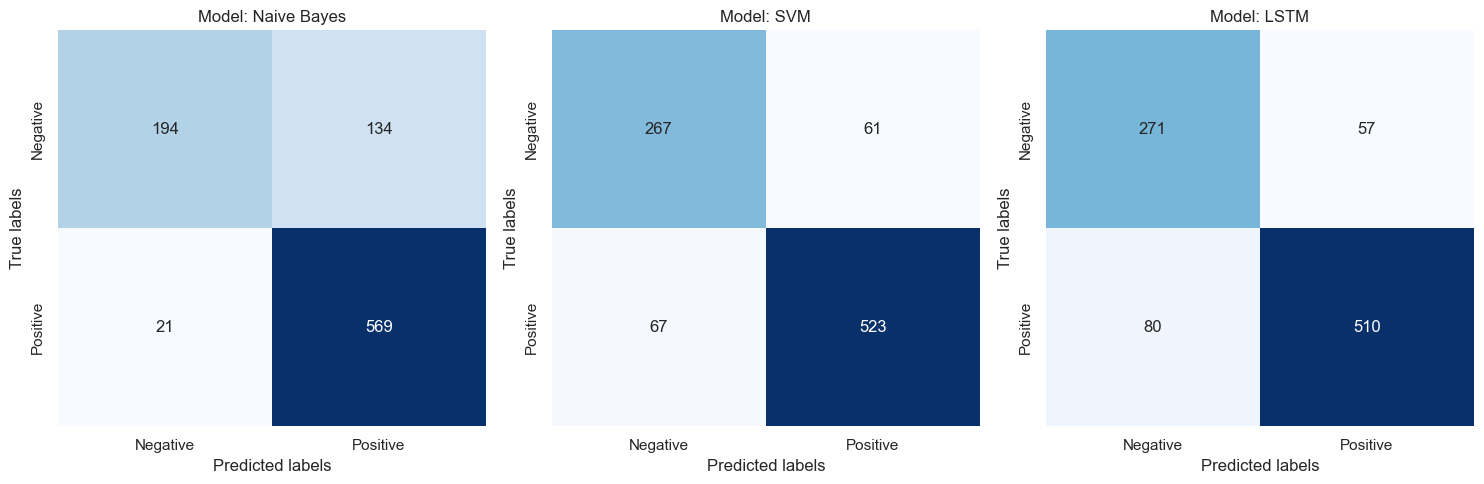

In [145]:
plot_confusion_matrices(model_names, models, test_data_list, true_labels_list)

In [146]:
compare_models_performance(model_names, models, test_data_list, true_labels_list)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Naive Bayes,0.831155,0.809388,0.964407,0.880124,0.777935
1,SVM,0.860566,0.895548,0.886441,0.890971,0.850233
2,LSTM,0.850763,0.899471,0.864407,0.881590,0.845313


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step


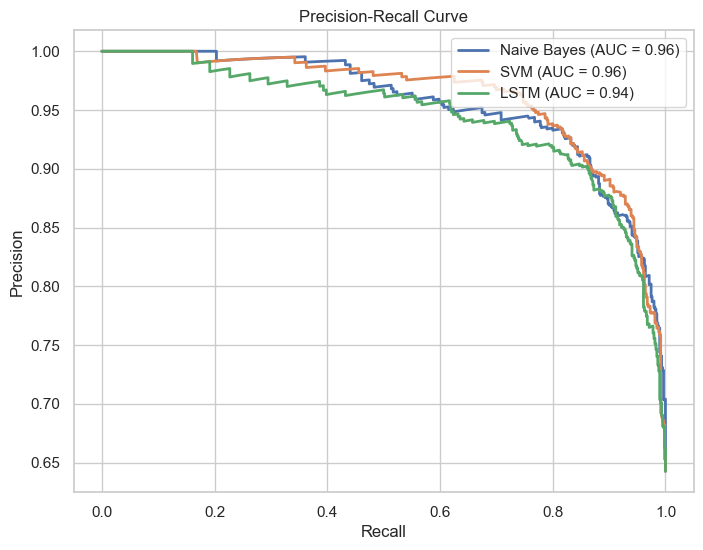

In [147]:
plot_precision_recall_curves(model_names, models, test_data_list, true_labels_list)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step


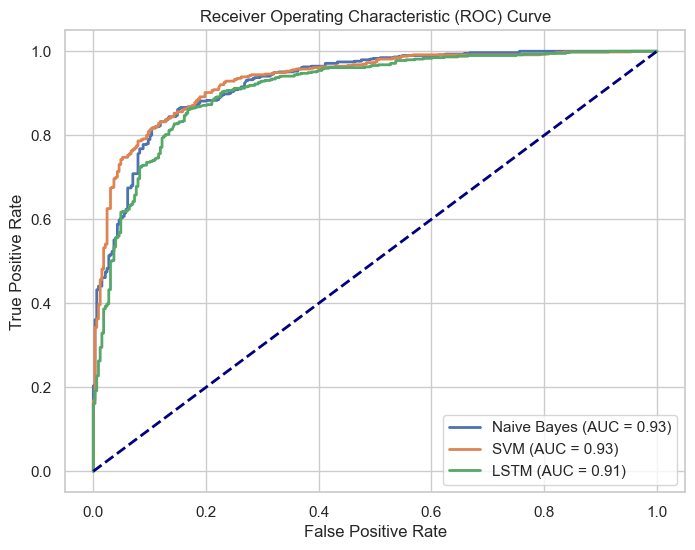

In [148]:
plot_roc_curves(model_names, models, test_data_list, true_labels_list)

Dựa trên các chỉ số của các phương pháp đánh giá mô hình phân lớp, có thể thấy mô hình SVM có các chỉ số gần như đều rất cao và thời gian thực thi cũng nhanh. Vì vậy, chúng tôi quyết định sử dụng mô hình SVM để triển khai dự án này.

In [150]:
import pickle

# Lưu vectorizer
with open('model/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Lưu model SVM
with open('model/svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

# Lưu label encoder
with open('model/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)